In [13]:
# GOAL 2 PANEL MODEL CODE

import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy as pt
import datetime


# Training Data
## IMPORTANT CODE NOTE: uncomment the data to run it & comment the other datas not in use

data = pd.read_csv('bed_bath_table_data.csv').drop(['product_category_name_english','revenue'],1)
#data = pd.read_csv('furniture_decor.csv').drop(['product_category_name_english','revenue'],1)
#data = pd.read_csv('health_beauty.csv').drop(['product_category_name_english','revenue'],1)
#data = pd.read_csv('construction_tools_lights_data.csv').drop(['product_category_name_english','revenue'],1)
    # reminder: take out C(month) here

# order_purchase_timestamp as date
format = '%Y-%m-%d'
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], format=format)

# bread up `order_purchase_timestamp` into additional variables
data['year'] = data['order_purchase_timestamp'].dt.year
data['month'] = data['order_purchase_timestamp'].dt.month
data['weekday'] = data['order_purchase_timestamp'].dt.weekday
# 0 = Monday, 6 = Sunday
data['isBlackFriday'] = np.where((data['order_purchase_timestamp']=='2017-11-24') | (data['order_purchase_timestamp'] == '2018-11-27'), 1, 0)
data['isWeekend'] = np.where((data['weekday']== 5) | (data['weekday'] == 6), 1, 0)


# TEST SET
# Predict from 2018-08-01 to 2018-10-31
## make dataframe with this date range as column
test = pd.DataFrame(columns=['order_purchase_timestamp', 'sales_volume', 'year', 'month', 'weekday', 'isBlackFriday', 'isWeekend'])
test['order_purchase_timestamp'] = pd.date_range(start="2018-08-01",end="2018-10-31")
test['year'] = test['order_purchase_timestamp'].dt.year
test['month'] = test['order_purchase_timestamp'].dt.month
test['weekday'] = test['order_purchase_timestamp'].dt.weekday
# set to 0 to fill column
test['sales_volume'] = 0
# 0 = Monday, 6 = Sunday
test['isBlackFriday'] = np.where((test['order_purchase_timestamp']=='2017-11-24') | (test['order_purchase_timestamp'] == '2018-11-27'), 1, 0)
test['isWeekend'] = np.where((test['weekday']== 5) | (test['weekday'] == 6), 1, 0)


# concatonate data2 and test
dat = pd.concat([data, test])


In [14]:
dat

,order_purchase_timestamp,sales_volume,year,month,weekday,isBlackFriday,isWeekend
0,2017-01-08,1,2017,1,6,0,1
1,2017-01-10,2,2017,1,1,0,0
2,2017-01-13,1,2017,1,4,0,0
3,2017-01-14,1,2017,1,5,0,1
4,2017-01-15,1,2017,1,6,0,1
...,...,...,...,...,...,...,...
87,2018-10-27,0,2018,10,5,0,1
88,2018-10-28,0,2018,10,6,0,1
89,2018-10-29,0,2018,10,0,0,0
90,2018-10-30,0,2018,10,1,0,0


In [15]:
# model matrices
# the data is the training data used for validation


## for bed_bath_table, change data to dat.iloc[:474]
## for furniture_decor, change data to dat.iloc[:479]
## for health_beauty, change data to dat.iloc[:473]

## for construction_tools_lights, remove C(month) from the equation & change data to dat.iloc[:55]


y, x = pt.dmatrices("sales_volume ~ C(year) + C(month) + C(weekday) + isBlackFriday + isWeekend", data = dat.iloc[:474], return_type='dataframe')


In [16]:
# Specify regression
reg = sm.OLS(endog=y, exog=x) 

# Fit regression with robust standard errors
# cluster based on 'order_purchase_timestamp'
# the data is the training data used for validation

## for bed_bath_table, change data to dat.iloc[:474]
## for furniture_decor, change data to dat.iloc[:479]
## for health_beauty, change data to dat.iloc[:473]

## for construction_tools_lights, remove C(month) from the equation & change data to dat.iloc[:55]

fit = reg.fit().get_robustcov_results(cov_type='cluster', groups=dat.iloc[:474, dat.columns.get_loc('order_purchase_timestamp')])

# Print results
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           sales_volume   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 2.401e+04
Date:                Fri, 16 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:35:36   Log-Likelihood:                -1811.6
No. Observations:                 474   AIC:                             3663.
Df Residuals:                     454   BIC:                             3746.
Df Model:                          19                                         
Covariance Type:              cluster                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.7495      2.156     

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 19
  'rank is %d' % (J, J_), ValueWarning)


In [18]:
# VALIDATE

# Store predictions and truth
# the validation set is [473:565] (the last three months of data for which 'sales_volume' is known)


# here the data is the validation data

## for bed_bath_table, change data to dat.iloc[474:566]
## for furniture_decor, change data to dat.iloc[479:571]
## for health_beauty, change data to dat.iloc[473:565]

## for construction_tools_lights, change data to dat.iloc[55:115]

xPred = pt.build_design_matrices([x.design_info], dat.iloc[474:566])

# fit prediction to validation set
pred = fit.predict(xPred).squeeze()
truth = dat.iloc[474:566, 1]


# sales errors
errors = pred - truth


# Calculate Absolute Percentage Error
pce = np.abs(errors/truth)*100


# Print MSE, Mean Absolute Error, 
#   and Mean Abs Percentage Error
print("Mean Squared Error: %s" % 
	str(np.mean(errors**2)))
print("Mean Absolute Error: %s" % 
	str(np.mean(np.abs(errors))))
print("Mean Absolute Percentage Error: %s" 
	% str(np.mean(pce)))
## by what percentage of the actual value were we incorrect (56.% is pretty bad)
## may be because of variables included or omitted, or just difficult to predict

Mean Squared Error: 319.8653529585417
Mean Absolute Error: 14.90901324009316
Mean Absolute Percentage Error: 83.74465336927645


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


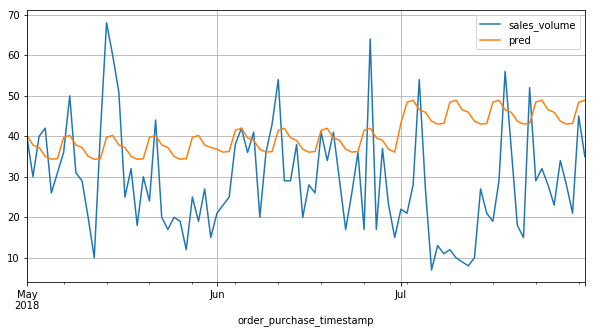

In [19]:
# PLOT VALIDATION SET OF PREDICTIONS VERSUS TRUTH
valid = dat.iloc[474:566]
valid['pred'] = pred

import plotly.express as px

valid.plot(x='order_purchase_timestamp', y=['sales_volume', 'pred'], figsize=(10,5), grid=True)


In [20]:
# PREDICT NEXT 3 MONTHS (Aug-Oct 2018) using whole training data

# predicting sales (total_price)
## same formula as from validation model

# here the data is the entire dataset up through July 2018

## for bed_bath_table, change data to dat.iloc[:566]
## for furniture_decor, change data to dat.iloc[:571]
## for health_beauty, change data to dat.iloc[:565]

## for construction_tools_lights, remove C(month) from the equation & change data to dat.iloc[:115]

y, x = pt.dmatrices("sales_volume ~ C(year) + C(month) + C(weekday) + isBlackFriday + isWeekend", data = dat.iloc[:566], return_type='dataframe')


# Specify regression
reg = sm.OLS(endog=y, exog=x) 

## panel model distinguished by using fixed effects on 'firm'
## --> breaking 'firm' into dummy variables; one obs per firm per year
##### (For Assignment 2) --> one obs per team per week; C(team)
##### (For Midterm) --> one obs per day; C(order_purchase_timestamp)



# Fit regression with robust standard errors
fit = reg.fit().get_robustcov_results(cov_type='cluster', groups=dat.iloc[:566, dat.columns.get_loc('order_purchase_timestamp')])
## cluster groups based on 'firm' so pass in corresponding column
## adjusts for cluster robust SE; SE changes without this
## higher SE = more honest about confidence in data set = less confident in results = more honest in ability to predict


# Print results
print(fit.summary())


# predict for last 22 rows of dat
xPred = pt.build_design_matrices([x.design_info], dat.iloc[566:])

prediction = fit.predict(xPred).squeeze()

# Compile prediction dataframe
test['sales_volume'] = prediction
pred = test[['order_purchase_timestamp','sales_volume']]

                            OLS Regression Results                            
Dep. Variable:           sales_volume   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 2.018e+04
Date:                Fri, 16 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:39:01   Log-Likelihood:                -2191.8
No. Observations:                 566   AIC:                             4424.
Df Residuals:                     546   BIC:                             4510.
Df Model:                          19                                         
Covariance Type:              cluster                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.1501      2.407     

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 19
  'rank is %d' % (J, J_), ValueWarning)


In [92]:
pred

,order_purchase_timestamp,sales_volume
0,2018-08-01,32.675281
1,2018-08-02,31.692351
2,2018-08-03,28.430882
3,2018-08-04,25.418194
4,2018-08-05,29.871244
...,...,...
87,2018-10-27,26.398398
88,2018-10-28,30.851448
89,2018-10-29,33.090267
90,2018-10-30,32.598665


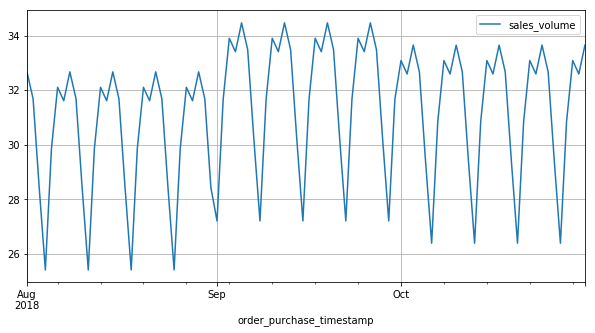

In [93]:
# Plot of the prediction over time
pred.plot(x='order_purchase_timestamp', y=['sales_volume'], figsize=(10,5), grid=True)

In [ ]:
## Used to calculate growth from Aug-Oct 2017 to Aug-Oct 2018
np.sum(pred['sales_volume'])